In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()     

In [102]:
import numpy as np
from math import sqrt


class Delaunay:

    def __init__(self, points, show_border=False, center=(0, 0)):
        
        # Okresl poczatkowy prostokąt i centrum
        center = np.asarray(center)
        max_x = max([p[0] for p in points])
        min_x = min([p[0] for p in points])
        max_y = max([p[1] for p in points])
        min_y = min([p[1] for p in points])
        
        radius = max(max_x-max_y, max_y-min_y)
        # Stwórz prostokąt okalający wszystkie punkty
        self.coords = [center+radius*np.array((-1, -1)),
                       center+radius*np.array((+1, -1)),
                       center+radius*np.array((+1, +1)),
                       center+radius*np.array((-1, +1))]

        # Słowniki do przechowywania sąsiadów i okręgów
        self.triangles = {}
        self.circles = {}
        
        # Do tworzenia scen, czy chcemy widziec punkty i trojkaty pomocnicze
        self.show_border = show_border
        
        self.points = points
        self.scenes = []

        # Create two CCW triangles for the frame
        T1 = (0, 1, 3)
        T2 = (2, 3, 1)
        self.triangles[T1] = [T2, None, None]
        self.triangles[T2] = [T1, None, None]

        # Oblicz centra oraz promienie dla punktow poczatkowych
        for t in self.triangles:
            self.circles[t] = self.circumcenter(t)
            
        for p in points:
            self.addPoint(p)
    
    def getTrianglesLines(self, triangles):
        triangles_lines = []
        for (a, b, c) in triangles:
            p1 = self.points[a]
            p2 = self.points[b]
            p3 = self.points[c]
            l1 = (p1, p2)
            l2 = (p1, p3)
            l3 = (p2, p3)
            triangles_lines.append(l1)
            triangles_lines.append(l2)
            triangles_lines.append(l3)
        return triangles_lines 
    
    def getBorderLines(self):
        triangles_lines = []
        for (a, b, c) in self.exportBorderTriangles():
            p1 = self.coords[a]
            p2 = self.coords[b]
            p3 = self.coords[c]
            l1 = (p1, p2)
            l2 = (p1, p3)
            l3 = (p2, p3)
            triangles_lines.append(l1)
            triangles_lines.append(l2)
            triangles_lines.append(l3)
        return triangles_lines  
        
    def circumcenter(self, tri):
        pts = np.asarray([self.coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        A = np.bmat([[2 * pts2, [[1],[1],[1]]],[[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1]))
        x = np.linalg.solve(A, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        radius = np.sum(np.square(pts[0] - center))
        return (center, radius)

    def inCircle(self, tri, p):
        center, radius = self.circles[tri]
        return np.sum(np.square(center - p)) <= radius
    
    def addPoint(self, p):
        p = np.asarray(p)
        idx = len(self.coords)
        self.coords.append(p)

        # Znajdz trojkaty, których okręgi zawierają p
        bad_triangles = []
        for T in self.triangles:
            if self.inCircle(T, p):
                bad_triangles.append(T)

        # Find the CCW boundary (star shape) of the bad triangles,
        # expressed as a list of edges (point pairs) and the opposite
        # triangle to each edge.
        boundary = []
        # Choose a "random" triangle and edge
        T = bad_triangles[0]
        edge = 0
        # get the opposite triangle of this edge
        while True:
            # Check if edge of triangle T is on the boundary...
            # if opposite triangle of this edge is external to the list
            tri_op = self.triangles[T][edge]
            if tri_op not in bad_triangles:
                # Insert edge and external triangle into boundary list
                boundary.append((T[(edge+1) % 3], T[(edge-1) % 3], tri_op))

                # Move to next CCW edge in this triangle
                edge = (edge + 1) % 3

                # Check if boundary is a closed loop
                if boundary[0][0] == boundary[-1][1]:
                    break
            else:
                # Move to next CCW edge in opposite triangle
                edge = (self.triangles[tri_op].index(T) + 1) % 3
                T = tri_op

        # Usun okręgi i niepoprawne trójkąty
        for T in bad_triangles:
            del self.triangles[T]
            del self.circles[T]

        # Retriangle the hole left by bad_triangles
        new_triangles = []
        
        for (e0, e1, tri_op) in boundary:
            # Create a new triangle using point p and edge extremes
            T = (idx, e0, e1)
            

            # Store circumcenter and circumradius of the triangle
            self.circles[T] = self.circumcenter(T)

            # Set opposite triangle of the edge as neighbour of T
            self.triangles[T] = [tri_op, None, None]

            # Try to set T as neighbour of the opposite triangle
            if tri_op:
                # search the neighbour of tri_op that use edge (e1, e0)
                for i, neigh in enumerate(self.triangles[tri_op]):
                    if neigh:
                        if e1 in neigh and e0 in neigh:
                            # change link to use our new triangle
                            self.triangles[tri_op][i] = T

            # Add triangle to a temporal list
            new_triangles.append(T)

        # Link the new triangles each another
        N = len(new_triangles)
        for i, T in enumerate(new_triangles):
            self.triangles[T][1] = new_triangles[(i+1) % N]   # next
            self.triangles[T][2] = new_triangles[(i-1) % N]   # previous
        
        
        # Dodanie sceny z wszystkimi punktami i liniami 
        new_triangles_lines = self.getTrianglesLines([(a-4, b-4, c-4) for (a, b, c) in new_triangles if a > 3 and b > 3 and c > 3])
        all_triangles_lines = self.getTrianglesLines([t for t in self.exportTriangles()])
        border_triangles_lines = self.getBorderLines()
        all_points = PointsCollection(self.points, color="blue")
        border_points = PointsCollection([x for x in self.coords[:4]], color="gray")
        analyzed_points = PointsCollection([x for x in self.coords[4:]], color="orange")
        actual_point = PointsCollection([p], color="red")
        all_lines = LinesCollection(all_triangles_lines, color="blue")
        new_lines = LinesCollection(new_triangles_lines, color="green")
        border_lines = LinesCollection(border_triangles_lines, color="gray")
        
        points = [border_points, all_points, analyzed_points, actual_point] if self.show_border else [all_points, analyzed_points, actual_point]
        
        lines = [border_lines, all_lines, new_lines] if self.show_border else [all_lines, new_lines]
        
        scene = Scene(points, lines)
        self.scenes.append(scene)

    def exportTriangles(self):
        # Pomijamy pierwsze 4 punkty, które były do stworzenia obwodu
        return [(a-4, b-4, c-4) for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]
                       
    def exportBorderTriangles(self):
        return [(a, b, c) for (a, b, c) in self.triangles if a < 4 or b < 4 or c < 4]

    def exportCircles(self):
        return [(self.circles[(a, b, c)][0], sqrt(self.circles[(a, b, c)][1]))
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

<IPython.core.display.Javascript object>


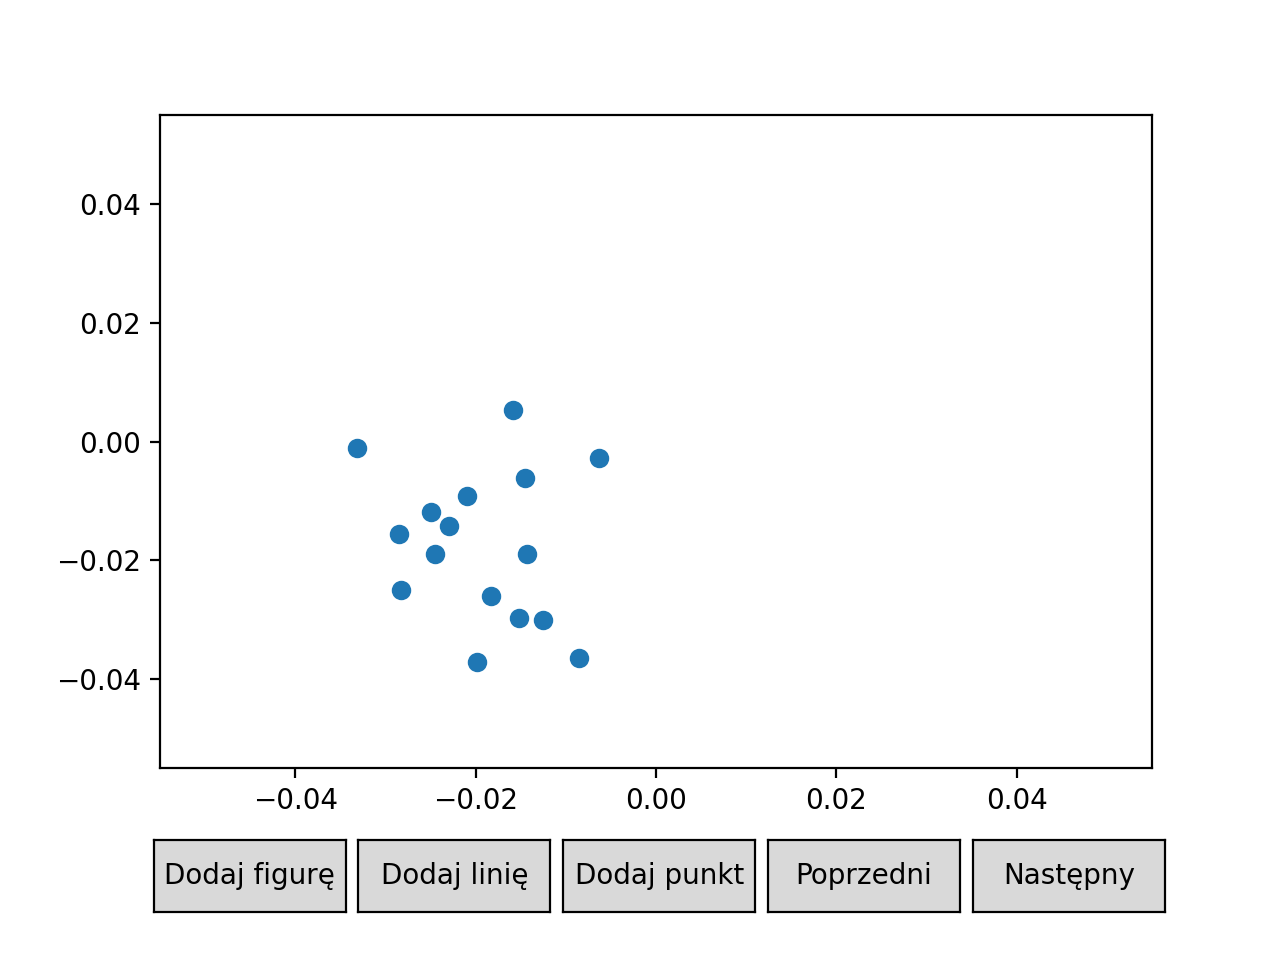

In [75]:
%matplotlib notebook
plot=Plot()
plot.draw()

In [76]:
points = plot.get_added_points()[0].points

In [108]:
dt = Delaunay(points, show_border=False)

<IPython.core.display.Javascript object>


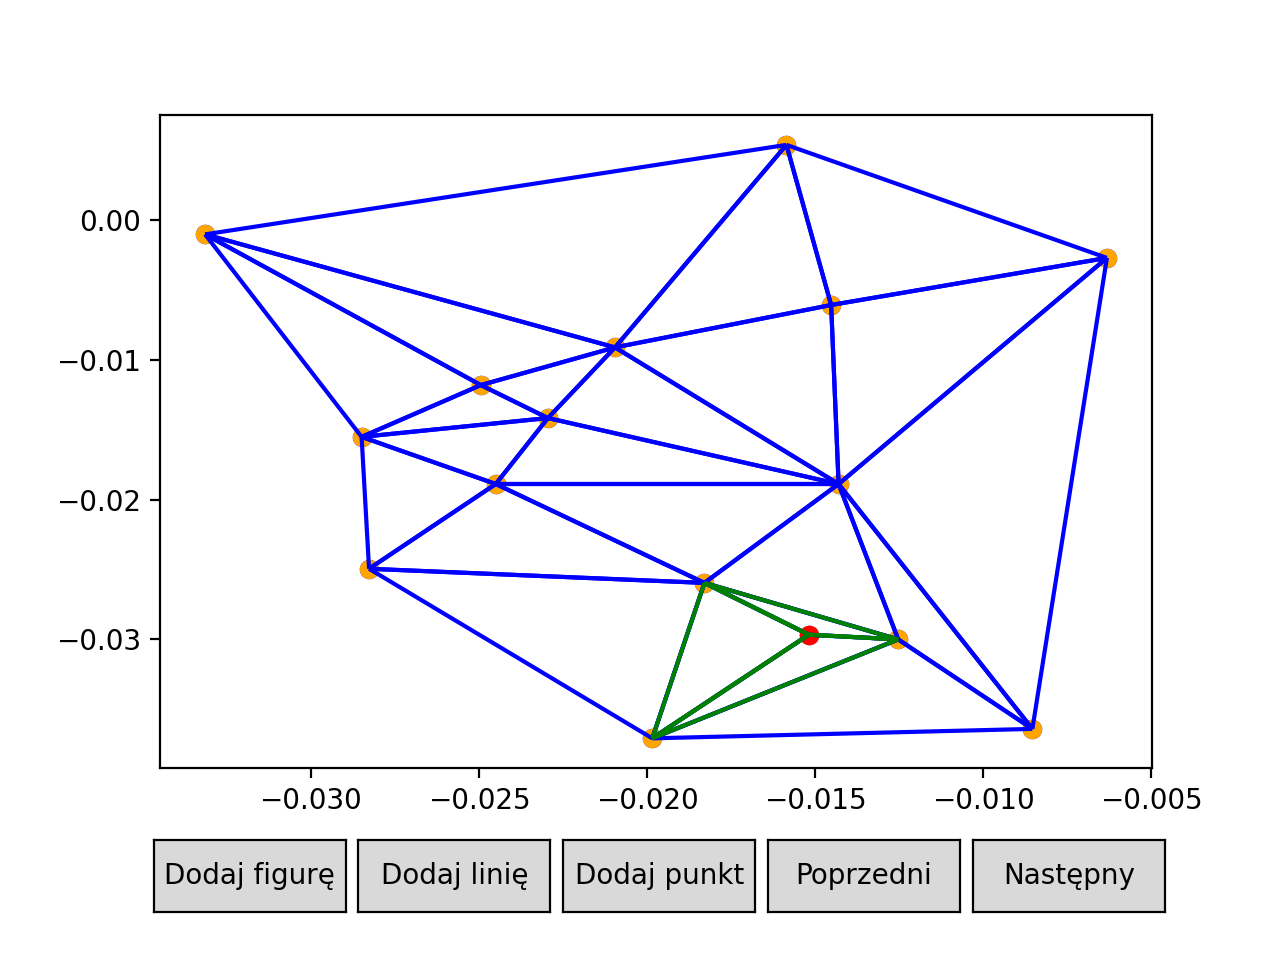

In [109]:
%matplotlib notebook
plot=Plot(dt.scenes)
plot.draw()